In [8]:
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

In [9]:
import py_entitymatching as em
import profiler
import pandas as pd
import qgrid

## Read input tables

In [10]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

In [11]:
len(A), len(B)

(1800, 1813)

In [12]:
A.head(2)

,id,title,authors,venue,year
0,conf/sigmod/Team95a,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,conf/sigmod/BunemanDHS96,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


In [13]:
B.head(2)

,id,title,authors,venue,year
0,304201,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,672964,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


In [14]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
len(A1), len(B1)

# But for the demo, we will use the entire table A and B

(481, 500)

## Block tables to get candidate set

In [15]:
# Explore tables to decide on the blocking attribute
# qgrid.show_grid(A)

In [16]:
# Explore to decide on the blocking attribute
# qgrid.show_grid(B)

Number of unique values: 10
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



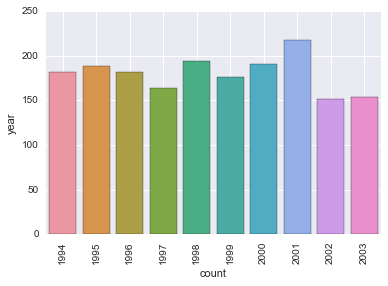

In [17]:
profiler.profile_table(A, 'year')

Number of unique values: 11
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



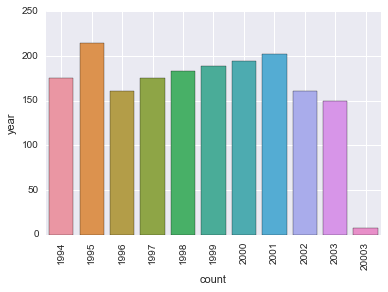

In [18]:
profiler.profile_table(B, 'year')

In [19]:
B.replace({'year':{
            20003:2003
        }}, inplace=True)

In [20]:
### Plan

### A, B -- AttrEquivalnce blocker [year]--------------------------| Candidate set

In [23]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )
len(C1)

328781

In [24]:
C1.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,conf/sigmod/Team95a,223794,Paradise: A Database System for GIS Applications,Paradise Team,1995,Nearest neighbor queries,"Nick Roussopoulos, Stephen Kelley, Frédéric Vincent",1995
1,1,conf/sigmod/Team95a,223788,Paradise: A Database System for GIS Applications,Paradise Team,1995,The LyriC language: querying constraint objects,"Alexander Brodsky, Yoram Kornatzky",1995


### Debug blocking output

In [25]:
# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B)

In [26]:
# add year attribute to the debugger output - 
#[This will change in the actual VLDB demo. Specifically, this will be embedded in debug blocker]
em.set_ltable(dbg, A)
em.set_rtable(dbg, B)
dbg = em.add_output_attributes(dbg, l_output_attrs=['year'], r_output_attrs=['year'])


In [27]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_venue,rtable_title,rtable_authors,rtable_venue,ltable_year,rtable_year
0,0,0.941176,journals/sigmod/Chaudhri98,273247,Workshop Report on Experiences Using Object Data Management in the Real-World,Akmal B. Chaudhri,SIGMOD Record,Workshop report on experiences using object data management in the real-world,Akmal B. Chaudhri,ACM SIGMOD Record,1998,1999
1,1,0.941176,journals/sigmod/Libkin99,344850,"Some Remarks on Variable Independence, Closure, and Orthographic Dimension in Constraint Databases",Leonid Libkin,SIGMOD Record,"Some remarks on variable independence, closure, and orthographic dimension in constraint databases",Leonid Libkin,ACM SIGMOD Record,1999,1998
2,2,0.928571,journals/sigmod/Hainaut03,959087,Research in database engineering at the University of Namur,Jean-Luc Hainaut,SIGMOD Record,Research in database engineering at the University of Namur,Jean-Luc Hainaut,ACM SIGMOD Record,2003,2002
3,3,0.928571,journals/sigmod/Dogac96,234900,Middle East Technical University Software Research and Development Center,Asuman Dogac,SIGMOD Record,Middle East Technical University Software Research and Development Center,Asuman Dogac,ACM SIGMOD Record,1996,1998
4,4,0.923077,journals/sigmod/Chen94,187460,Database Research at NTHU and ITRI,Arbee L. P. Chen,SIGMOD Record,Database research at NTHU and ITRI,Arbee L. P. Chen,ACM SIGMOD Record,1994,1995


In [28]:
# Revised blocking plan

# A, B -- AttrEquivalnce blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [29]:
profiler.profile_table(A, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1797
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 3D Geographic Network Displays, 50,000 Use..."


In [30]:
profiler.profile_table(B, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1803
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 2Q: A Low Overhead High Performance Buffer..."


In [32]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)
len(C2)

457884

In [34]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

736127

In [35]:
# Check again to see if we are dropping any potential matches
dbg = em.debug_blocker(C, A, B)
em.set_ltable(dbg, A)
em.set_rtable(dbg, B)
dbg = em.add_output_attributes(dbg, l_output_attrs=['year'], r_output_attrs=['year'])

In [36]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_venue,rtable_title,rtable_authors,rtable_venue,ltable_year,rtable_year
0,0,0.400000,journals/sigmod/MeltonE02,290604,An Early Look at XQuery,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record,2002,1998
1,1,0.400000,journals/sigmod/EisenbergM00,290604,SQL Standardization: The Next Steps,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record,2000,1998
2,2,0.400000,journals/sigmod/EisenbergM02,290604,SQL/XML is Making Good Progress,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record,2002,1998
3,3,0.384615,journals/sigmod/Snodgrass03c,390004,Developments at ACM TODS,Richard T. Snodgrass,SIGMOD Record,Reminiscences in influential papers,Richard Snodgrass,ACM SIGMOD Record,2003,1998
4,4,0.384615,journals/sigmod/Snodgrass03c,290599,Developments at ACM TODS,Richard T. Snodgrass,SIGMOD Record,Reminiscences on influential papers,Richard Snodgrass,ACM SIGMOD Record,2003,1998


### Match tuple pairs in candidate set

#### 1. Sample candidate set  --> S
#### 2. Label S --> L  
#### 3. Split L into development set  and evaluation set 
#### 4. Select best learning-based matcher M, using development set
#### 5. Evaluate M using evaluation set

In [37]:
# Sample  candidate set
S = em.sample_table(C, 450)

In [58]:
# Label S
L = em.label_table(S, 'gold')

In [39]:
# For the demo, use pre-labeled data
L = em.read_csv_metadata('labeled_data_demo.csv', ltable=A, rtable=B)
len(L)

450

In [40]:
# Split L into development  and evaluation
development_evaluation = em.split_train_test(L, train_proportion=0.7)
development = development_evaluation['train']
evaluation = development_evaluation['test']

### Selecting the best learning-based matcher using development set


#### 1. Create a set of ML-matchers
#### 2. Generate features --> feature_table
#### 3. Extract feature vectors using development set  and feature_table
#### 4. Select best learning-based matcher using k-fold cross validation
#### 5. Debug the selected matcher (and repeat the above steps)

In [41]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree')
svm = em.SVMMatcher(name='SVM')
rf = em.RFMatcher(name='RF')
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg')
ln = em.LinRegMatcher(name='LinReg')

In [42]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

In [43]:
# List the feature names generated
feature_table['feature_name']

0             title_title_jac_qgm_3_qgm_3
1         title_title_cos_dlm_dc0_dlm_dc0
2                         title_title_mel
3                    title_title_lev_dist
4                     title_title_lev_sim
5         authors_authors_jac_qgm_3_qgm_3
6     authors_authors_cos_dlm_dc0_dlm_dc0
7                     authors_authors_mel
8                authors_authors_lev_dist
9                 authors_authors_lev_sim
10                          year_year_exm
11                          year_year_anm
12                     year_year_lev_dist
13                      year_year_lev_sim
Name: feature_name, dtype: object

In [44]:
# Select all features
feature_table_iter1 = feature_table

In [45]:
# Extract feature vectors
feature_vectors_dev_iter1 = em.extract_feature_vecs(development, 
                            feature_table=feature_table_iter1, 
                            attrs_after='gold',
                            show_progress=False) 

In [46]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_iter1, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
        k=5,
        target_attr='gold', metric='f1')

In [47]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1162b8dd8>,5,0.884615,0.818182,0.800000,0.666667,0.871795,0.808252
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1162b8be0>,5,0.833333,0.820513,0.810811,0.750000,0.810811,0.805094
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x1162b8828>,5,0.750000,0.628571,0.717949,0.600000,0.837209,0.706746
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x1162b8a20>,5,0.695652,0.580645,0.727273,0.740741,0.625000,0.673862
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x1162b88d0>,5,0.744186,0.580645,0.705882,0.692308,0.625000,0.669604
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x1162b8860>,5,0.714286,0.580645,0.727273,0.740741,0.588235,0.670236


### Debug matcher
#### 1. Split feature vectors into train and test
#### 2. Debug matcher using train and test

In [48]:
# Debug RF

# Split feature vectors to train and test
train_test = em.split_train_test(feature_vectors_dev_iter1, train_proportion=0.5, random_state=3)
train = train_test['train']
test = train_test['test']

In [49]:
# Debug RF  using GUI
em.vis_debug_rf(rf, train, test, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
        target_attr='gold')

In [50]:
# Add a new feature to do jaccard on title + authors

# Create a function
def title_authors_jac_ws_ws(ltuple, rtuple):
    l_title_author = ' '.join([ltuple['title'], ltuple['authors']])
    r_title_author = ' '.join([rtuple['title'], rtuple['authors']])
    return em.jaccard(em.tok_wspace(l_title_author), em.tok_wspace(r_title_author))

In [51]:
# Add the function to feature table
feature_table = em.get_features_for_matching(A, B)
em.add_blackbox_feature(feature_table, 'title_authors_jac_ws_ws', title_authors_jac_ws_ws)
feature_table_iter2 = feature_table

In [52]:
feature_vectors_dev_iter2 = em.extract_feature_vecs(development, 
                            feature_table=feature_table_iter2, 
                            attrs_after='gold',
                            show_progress=False) 

In [53]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_iter2, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'],
        k=5,
        target_attr='gold', metric='f1')

In [54]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1162b8dd8>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1162b8be0>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x1162b8828>,5,0.648649,0.888889,0.631579,0.714286,0.764706,0.729622
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x1162b8a20>,5,0.977778,0.944444,1.000000,1.000000,1.000000,0.984444
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x1162b88d0>,5,0.842105,0.969697,0.800000,0.930233,0.975610,0.903529
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x1162b8860>,5,0.952381,1.000000,0.933333,0.977778,0.975610,0.967820


### Evaluate matcher using test set

#### 1. Extract feature vectors (using feature_subset_iter2) 
#### 2. Train matcher using  feature vectors generated from development set
#### 3. Predict using trained matcher
#### 4. Evaluate the result

In [55]:
# Extract feature vectors
feature_vectors_eval = em.extract_feature_vecs(evaluation, feature_table=feature_table_iter2,
                                               attrs_after='gold', show_progress=False)


In [56]:
# Train using feature vectors from development set
rf.fit(table=feature_vectors_dev_iter2, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'], 
       target_attr='gold')
# Predict M 
predictions = rf.predict(table=feature_vectors_eval, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'gold'], 
              append=True, target_attr='predicted', inplace=False)

In [57]:
# Evaluate the result
eval_result = em.eval_matches(predictions, 'gold', 'predicted')
em.print_eval_summary(eval_result)

Precision : 100.0% (41/41)
Recall : 95.35% (41/43)
F1 : 97.62%
False positives : 0 (out of 41 positive predictions)
False negatives : 2 (out of 94 negative predictions)
